In [1]:
!pip install -q torchinfo

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [4]:
seed = 1202
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [5]:
!wget https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv

--2025-07-08 01:23:44--  https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv
Resolving www.cryptodatadownload.com (www.cryptodatadownload.com)... 35.173.69.207
Connecting to www.cryptodatadownload.com (www.cryptodatadownload.com)|35.173.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111438 (109K) [text/csv]
Saving to: ‘Bithumb_BTCKRW_d.csv’

Bithumb_BTCKRW_d.cs 100%[===================>] 108.83K  --.-KB/s    in 0.04s   

2025-07-08 01:23:45 (2.93 MB/s) - ‘Bithumb_BTCKRW_d.csv’ saved [111438/111438]



In [6]:
df = pd.read_csv("/kaggle/working/Bithumb_BTCKRW_d.csv", skiprows=1)
df['Date'] = df['Date'].apply(pd.Timestamp)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print(df.shape)
print(df)

(1267, 8)
            Unix Timestamp  Symbol      Open      High       Low     Close  \
Date                                                                         
2017-05-22    1.495411e+09  BTCKRW   3027000   3195000   2966000   3104000   
2017-05-23    1.495498e+09  BTCKRW   3104000   3281000   3081000   3206000   
2017-05-24    1.495584e+09  BTCKRW   3206000   4314000   3206000   4175000   
2017-05-25    1.495670e+09  BTCKRW   4175000   4840000   3102000   4199000   
2017-05-26    1.495757e+09  BTCKRW   4199000   4200000   2900000   3227000   
...                    ...     ...       ...       ...       ...       ...   
2020-11-16    1.605485e+09  BTCKRW  17679000  18440000  17560000  18264000   
2020-11-17    1.605571e+09  BTCKRW  18264000  19411000  18179000  19350000   
2020-11-18    1.605658e+09  BTCKRW  19350000  20300000  19058000  19713000   
2020-11-19    1.605744e+09  BTCKRW  19713000  20026000  19379000  19799000   
2020-11-20    1.605830e+09  BTCKRW  19799000  20151000

In [7]:
df_close = df.loc[:, ["Close"]]
print(df_close.tail())

               Close
Date                
2020-11-16  18264000
2020-11-17  19350000
2020-11-18  19713000
2020-11-19  19799000
2020-11-20  20072000


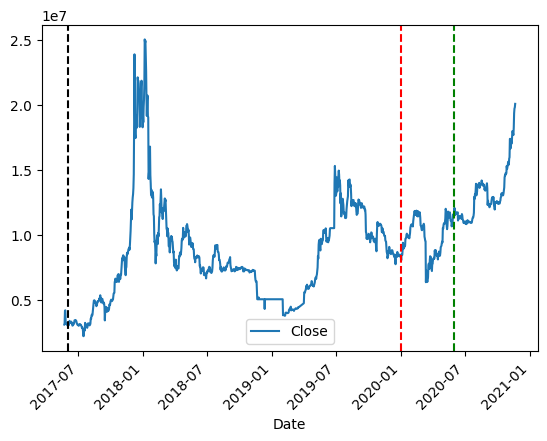

In [8]:
ax = df_close.plot(rot=45)
ax.axvline("2017-06-01", linestyle="--", c="black")
ax.axvline("2020-01-01", linestyle="--", c="red")
ax.axvline("2020-06-01", linestyle="--", c="green")

In [9]:
df_train = df_close[
  (df_close.index >= "2017-06-01")&(df_close.index < "2020-01-01")
]
print(df_train[:5])

              Close
Date               
2017-06-01  3142000
2017-06-02  3169000
2017-06-03  3110000
2017-06-04  3061000
2017-06-05  3188000


In [10]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df_train[:5])
data

array([[0.63779528],
       [0.8503937 ],
       [0.38582677],
       [0.        ],
       [1.        ]])

In [11]:
scaler.inverse_transform(data)

array([[3142000.],
       [3169000.],
       [3110000.],
       [3061000.],
       [3188000.]])

In [12]:
class BitcoinDataset(Dataset):
  def __init__(self, split="train", seq_len=4):
    self.split = split
    self.seq_len = seq_len

    self.date_range = {
      "train": ["2017-06-01", "2020-01-01"],
      "val": ["2020-01-01", "2020-06-01"],
      "test": ["2020-06-01", "2020-11-21"]
    }

    self.data = self._load_data(self.date_range[self.split])
    self.data, self.labels = self._transform(self.data, self.seq_len)

  def _load_data(self, date_range):
    df = pd.read_csv("/kaggle/working/Bithumb_BTCKRW_d.csv", skiprows=1)
    df['Date'] = df['Date'].apply(pd.Timestamp)
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

    df_close = df.loc[:, ["Close"]]
    df = df_close[
      (df_close.index >= date_range[0])&(df_close.index < date_range[1])
    ]

    self.scaler = MinMaxScaler()
    data = self.scaler.fit_transform(df)
    return data

  def _transform(self, data, seq_len):
    x, y = [], []

    for i in range(len(data) - seq_len - 1):
      x_i = data[i:i+seq_len]
      y_i = data[i+1:i+seq_len+1]
      x.append(x_i)
      y.append(y_i)

    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)

    return x_tensor, y_tensor

  def __getitem__(self, i):
    return self.data[i], self.labels[i]

  def __len__(self):
    return len(self.data)

In [13]:
trainset = BitcoinDataset()
valset = BitcoinDataset(split="val")
testset = BitcoinDataset(split="test")

print(len(trainset), len(valset), len(testset))

927 147 168


In [14]:
def plot_sequence(x, y):
  plt.ylabel("Scaled Close")
  plt.xlabel("Time Bars")
  plt.plot(range(len(x)), x, color='r', label='Features')
  plt.plot(range(1, len(x)+1), y, color='b', linestyle='--', label='Target')
  plt.legend()

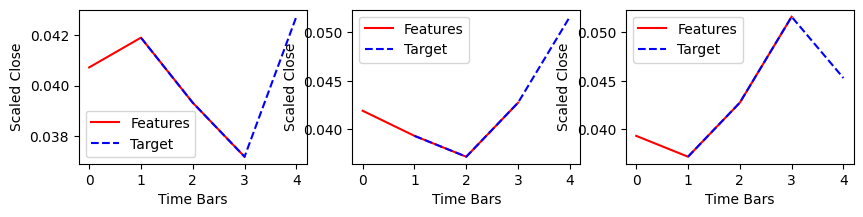

In [15]:
plt.figure(figsize=(10,2))
for i, (x, y) in enumerate(trainset):
  plt.subplot(1, 3, i+1)
  plot_sequence(x, y)

  if i == 2:
    break